# Лабораторна робота 3 з "Асиметричних криптосистем та протоколів"
## Тема: Криптосистема Рабіна; Атака на протокол доведення знання без розголошення

**Виконали**\
Дигас Богдан, ФІ-03\
Починок Юрій, ФІ-03

## Підключаємо бібліотеки

In [2015]:
import random

rand = random.SystemRandom()
from sympy.ntheory import jacobi_symbol
import math

## Вибираємо бітову довжину $p$ і $q$ - дільників нашого публічного ключа

In [2016]:
bit_length = 256

## Допоміжні функції

### Перевірка на простоту, перетворення числа у бінарному представленні на десяткове та розширений алгоритм Евкліда

In [2017]:
def decomposing_number(n, a):
    exp = n - 1
    while not exp & 1:  # while exp is even
        exp >>= 1  # divide by 2
    if pow(a, exp, n) == 1:
        return True  # number is composite
    while exp < n - 1:
        if pow(a, exp, n) == n - 1:
            return True  # number is composite
        exp <<= 1  # multiply by 2
    return False  # number is probably prime


def miller_rabbin_test(n, k=20):
    for i in range(k):
        a = rand.randrange(1, n - 1)
        if not decomposing_number(n, a):
            return False  # number is composite
    return True  # number is probably prime


def bin_to_dec(bin_n):
    dec_n = 0
    res = 0
    for i in range(len(bin_n)):
        res = bin_n[len(bin_n) - i - 1] * 2**i
        dec_n += res
    return dec_n


def extended_gcd(a, b):
    if a == 0:
        return b, 0, 1
    gcd, x1, y1 = extended_gcd(b % a, a)

    x = y1 - (b // a) * x1
    y = x1

    return gcd, x, y

### Генерація випадкових чисел

In [2018]:
def generate_bit_seq(n):
    seq = [0] * n
    for i in range(n):
        seq[i] = rand.randint(0, 1)
    return seq


def L20(n):
    seq = generate_bit_seq(20)
    result = [0] * n
    for i in range(20):
        result[i] = seq[i]
    for i in range(20, n):
        result[i] = result[i - 3] ^ result[i - 5] ^ result[i - 9] ^ result[i - 20]
    return result

### Генерація простого числа

In [2019]:
def generate_prime_number(x):
    res = [1, 0, 0]
    while miller_rabbin_test(bin_to_dec(res)) == False:
        res = L20(x)
    return res

### Генерація простих чисел Блюма

In [2020]:
def generate_blum_primes(n):
    p = bin_to_dec(generate_prime_number(n))
    while (p - 3) % 4 != 0:
        p = bin_to_dec(generate_prime_number(n))

    q = bin_to_dec(generate_prime_number(n))
    while (q - 3) % 4 != 0:
        q = bin_to_dec(generate_prime_number(n))

    return p, q

### Швидке обчислення квадратного кореня за Блюма $(p, q = 4k + 3, k \in \mathrm{Z})$

In [2021]:
def fast_square_blum(y, p, q):  # x^2 = y(mod n), n = p*q, p & q = 4k + 3
    n = p * q
    s_1 = pow(y, (p + 1) // 4, p)  # '//' is for it to be int, not float
    s_2 = pow(y, (q + 1) // 4, q)
    _, u, v = extended_gcd(p, q)

    return (
        (u * p * s_2 + v * q * s_1) % n,
        (u * p * s_2 - v * q * s_1) % n,
        ((-1) * u * p * s_2 + v * q * s_1) % n,
        ((-1) * u * p * s_2 - v * q * s_1) % n,
    )  # ++, +-, -+, --


def extended_fast_square_blum(y, p, q, b):
    n = p * q
    s_1 = pow(y, (p + 1) // 4, p)  # '//' is for it to be int, not float
    s_2 = pow(y, (q + 1) // 4, q)
    _, u, v = extended_gcd(p, q)

    return (
        (-(1) * b * pow(2, -1, p * q) + (u * p * s_2 + v * q * s_1)) % n,
        (-(1) * b * pow(2, -1, p * q) + (u * p * s_2 - v * q * s_1)) % n,
        (-(1) * b * pow(2, -1, p * q) + ((-1) * u * p * s_2 + v * q * s_1)) % n,
        (-(1) * b * pow(2, -1, p * q) + ((-1) * u * p * s_2 - v * q * s_1)) % n,
    )  # ++, +-, -+, --

In [2022]:
# Перевірка на уважність)))))))))))

# x = 4
# test_roots = fast_square_blum(x, 19, 11)
# print(test_roots)
# for root in test_roots:
#     print(pow(root, 2, 11*19))

# Перевірка на уважність)))))))
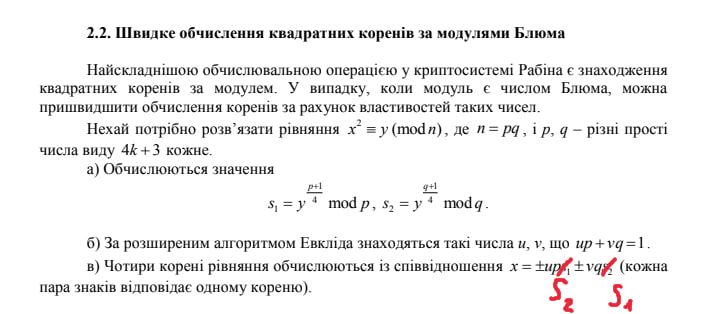

### Форматування та видалення форматування повідомлення

In [2023]:
def format(m, n):
    l = math.ceil((len(bin(n)) - 2) / 8)
    if math.ceil((len(bin(m)) - 2) / 8) < (l - 10):
        # print(l, math.ceil((len(bin(m))-2)/8))
        r = rand.randrange(0, 2**64)  # TO DO: make r random
        x = 255 * 2 ** (8 * (l - 2)) + m * 2**64 + r
        # print("Passed the condition")
        return x
    else:
        return m


def unformat(m, n):
    l = len(bin(n)) - 2
    # print(l)
    m = bin(m)
    # print(m,len(m))
    x = ""
    # print(l)
    for i in range(10, (len(m) - 64)):
        x += m[i]
    return int(x, 2)

In [2024]:
# Перевірка на уважність)))))))))))

#p, q = generate_blum_primes(bit_length)
# n = p*q
# M = 7532235123452342552455574234234556324546554673185648762345534656545234523452346234623452345234523452345234522345234562346236564
# f = format(M, n)
# print(bin(M))
# print(bin(f))
# # print(n)
# uf = unformat(f, n)
# print(uf)


# Перевірка на уважність)))))))
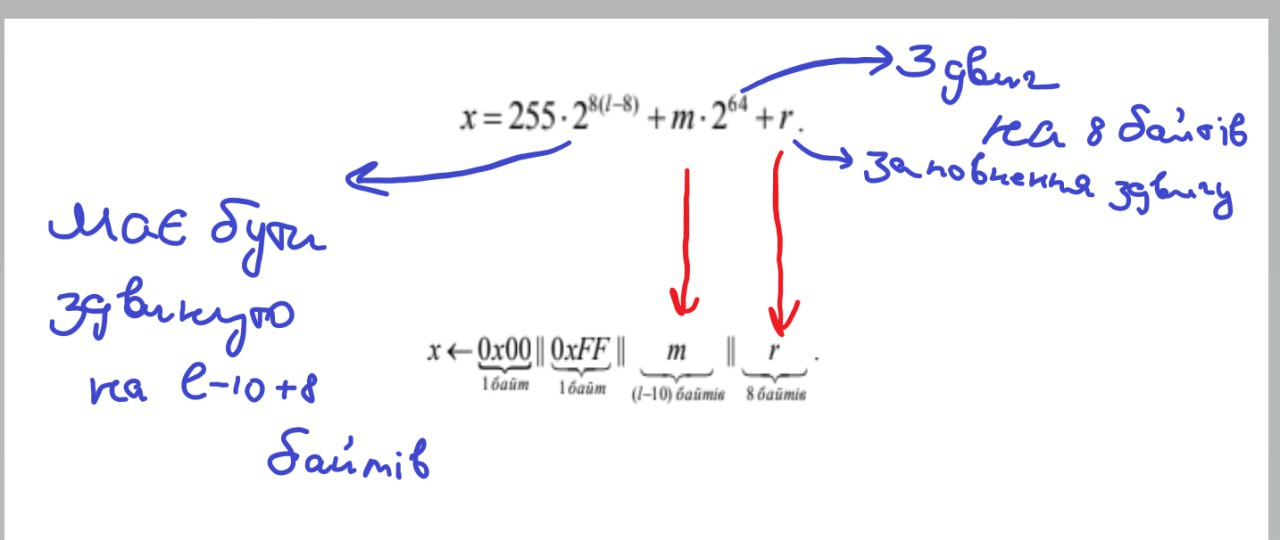

## Прописуємо інтерфейс користувача

In [2025]:
class User:
    __p = None  # private key, key pair (p,q)
    __q = None
    __public_n = None
    __k = None

    def __init__(self):
        self.__p, self.__q = generate_blum_primes(bit_length)
        self.__public_n = self.__p * self.__q
        self.__public_b = rand.randrange(0, self.__public_n)

    def get_public_key(self):
        return self.__public_n

    def get_public_b(self):
        return self.__public_b

    def Rabin_decrypt(self, C):
        y, c_1, c_2 = C
        roots = fast_square_blum(y, self.__p, self.__q)
        for root in roots:
            root_c_1 = root % 2
            root_c_2 = int(jacobi_symbol(root, self.__public_n) == 1)
            # print(root, root_c_1, jacobi_symbol(root, self.__public_n))
            if root_c_1 == c_1 and root_c_2 == c_2:
                return unformat(root, self.__public_n)  # Returning M
        print("If you got to this point, there are no useful roots and something went horribly wrong")

    def extended_Rabin_decrypt(self, C):
        y, c_1, c_2 = C
        roots = extended_fast_square_blum(
            y + pow(self.__public_b, 2, self.__public_n) * pow(4, -1, self.__public_n),
            self.__p,
            self.__q,
            self.__public_b,
        )
        for root in roots:
            temp = (
                root + self.__public_b * pow(2, -1, self.__public_n)
            ) % self.__public_n
            root_c_1 = temp % 2
            root_c_2 = int(jacobi_symbol(temp, self.__public_n) == 1)
            # print(root, root_c_1, jacobi_symbol(root, self.__public_n))
            if root_c_1 == c_1 and root_c_2 == c_2:
                return unformat(root, self.__public_n)  # Returning M
        print("If you got to this point, there are no useful roots and something went horribly wrong")

    def Rabin_sign(self, M):
        while True:  # reformat until we satisfy the condition
            x = format(M, self.__public_n)
            print("Formatting while signing")
            if (
                jacobi_symbol(x, self.__p) == 1 and jacobi_symbol(x, self.__q) == 1
            ):  # condition: (x, p) == (x, q) == 1
                break
        # At this point the condition should be satisfied

        roots = fast_square_blum(x, self.__p, self.__q)
        return (
            M,
            roots[rand.randrange(0, 3)],
        )  # Return the message and the random root as a pair (M[essage], S[ign])

## Прописуємо загальний інтерфейс роботи з користувачем

In [2026]:
def Rabin_encrypt(M, n):
    x = format(M, n)
    y = pow(x, 2, n)  # y = x^2 mod n
    c_1 = x % 2
    c_2 = int(jacobi_symbol(x, n) == 1)
    return (y, c_1, c_2)


def extended_Rabin_encrypt(M, n, b):
    x = format(M, n)
    y = (x * (x + b)) % n
    temp = (x + b * pow(2, -1, n)) % n
    c1 = temp % 2
    c2 = int(jacobi_symbol(temp, n) == 1)
    return (y, c1, c2)


# Example: Rabin_encrypt(x, User.get_public_key())


def Rabin_verify(M, S, n):
    supposed_M = pow(S, 2, n)
    return M == unformat(supposed_M, n)

# Тестуємо функціонал

In [2027]:
A = User()
M = 512
_, S = A.Rabin_sign(M)

Formatting while signing
Formatting while signing
Formatting while signing
Formatting while signing


## Отримання параметрів серверу


In [2028]:
import requests

session = requests.Session()

res = session.get(
    f"http://asymcryptwebservice.appspot.com/rabin/serverKey?keySize={2*bit_length}" # 2 times the bit_length, since our bit_length is for p and q, not n
)
server_n = int(res.json()["modulus"], 16)
server_b = int(res.json()["b"], 16)
print("server n =", server_n)
print("our    n =", A.get_public_key())
print("server b =", server_b)

server n = 6743166738184023385126067420288287654001361274565347996382727053879663690208493960744186719057592006352422519814306944384120311475734227429613322177646113
our    n = 2149764843282957839165772618029309094891931961482474381420016096621672350241147862841414458295441791452864317276367015443209678492572403358862068021007681
server b = 152587896295041828815110468666821559977355791040921288785851285409889714605024270446517182479810619433528568919858387702343449184776480698993191320789395


## Перевірка розкодування

In [2029]:
encrypt = session.get(
    f"http://asymcryptwebservice.appspot.com/rabin/encrypt?modulus={hex(A.get_public_key())[2:]}&b={hex(A.get_public_b())[2:]}&message={hex(M)[2:]}&type=BYTES"
)
server_C = int(encrypt.json()["cipherText"], 16)
server_c1 = encrypt.json()["parity"]
server_c2 = encrypt.json()["jacobiSymbol"]
print("server C =", server_C)
print("server c1 =", server_c1)
print("server c2 =", server_c2)
C = (server_C, server_c1, server_c2)
print(A.extended_Rabin_decrypt(C))

server C = 226229789601419161740856618161054737184103227925970059974229732471337824666032438078588383958093446300751530016195982723810239154609758162657473261494841
server c1 = 1
server c2 = 1
512


## Перевірка кодування

In [2030]:
y, c1, c2 = extended_Rabin_encrypt(M, server_n, server_b)
answer = session.get(
    f"http://asymcryptwebservice.appspot.com/rabin/decrypt?cipherText={hex(y)[2:]}&expectedType=BYTES&parity={c1}&jacobiSymbol={c2}"
).json()["message"]
print("M =", int(answer, 16))

M = 512


## Перевірка підпису

In [2031]:
server_sign = int(session.get(f'http://asymcryptwebservice.appspot.com/rabin/sign?message={hex(M)[2:]}&type=BYTES').json()["signature"], 16)
print(Rabin_verify(M, server_sign, server_n))

True


## Сервер перевіряє підпис

In [2032]:
answer = session.get(
    f"http://asymcryptwebservice.appspot.com/rabin/verify?message={hex(M)[2:]}&type=BYTES&signature={hex(S)[2:]}&modulus={hex(A.get_public_key())[2:]}"
)
print(answer.json()["verified"])

True


## Атака на протокол доведення знання розкладу числа на прості множники

In [2033]:
server_n_attack = int(session.get(f'http://asymcryptwebservice.appspot.com/znp/serverKey').json()["modulus"], 16)
tries = 0
while True:
    tries = tries + 1
    t = rand.randrange(0, server_n_attack)
    y = pow(t, 2, server_n_attack)

    # Кидаємо його серваку
    r = session.get(f'http://asymcryptwebservice.appspot.com/znp/challenge?y={hex(y)[2:]}')

    server_z = int(r.json()["root"], 16)
    if(t != server_z and t != (-1)*server_z):
        divisor, _, _ = extended_gcd(t + server_z, server_n_attack)
        if (divisor == 1 or divisor == server_n_attack):
            continue
        break
print("divisor =", divisor)
print("server_n =", server_n_attack)
print(tries)

divisor = 152843950477460209703218217791327058106407972663007922742123002928273787771948489941619204841607394502234092253730179303523469916436377108696993540877008041129320897548773177653083552880811747850762385719873508168099274318383633742344064806954821094370850788415298145493087207831754561286982603167322936481303
server_n = 21091067015090355752076168066344730124722270609811117271427009664848565456158923325528714703766924023983448760983133375961333278045806231538938402277137761654762780206002446441050421486496224173376073060181042267361173035721982344663769054729835330977490010828850719602650677100340090907005641964870190610338698885224539608957192672048113826330690043882503808965958221079240865004816298452812927459678109894554390114487579897651451293926420631115016831406901464878177094368699204252457884939306675101847250260717811772218729361868661569431006445859272875791495156331670115549145358510147891737773864362271824258638909
3


# **Висновок:**
 - **Будьте уважні!**
 - Працювати з сервером, як виявляється, легко
 - Лаба в принципі теж дуже легка, аби тільки уважним не треба було бути
 - Практичні результати були наведені під час захисту роботи